## Problem Statement 
The task is to analyze the customer reviews for various products. You are supposed to create a report that
classifies the products based on the customer reviews.

## Project Objective
1. Find various trends and patterns in the reviews data, create useful insights that
best describe the product quality.
2. Classify each review based on the sentiment associated with the same.

### Importing Libraries

In [1]:
#! pip uninstall wasabi -y

In [2]:
#! pip install wasabi==0.9.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore') 

In [4]:
#!pip install spacy -q
#!python -m spacy download en_core_web_sm -q

In [5]:
import en_core_web_sm

nlp = en_core_web_sm.load()

In [6]:
nlp = spacy.load("en_core_web_sm")

## Data Description 

In [7]:
tw_data = pd.read_csv(r'C:/Users/Astha/Downloads/Project/Reviews.csv')
                      

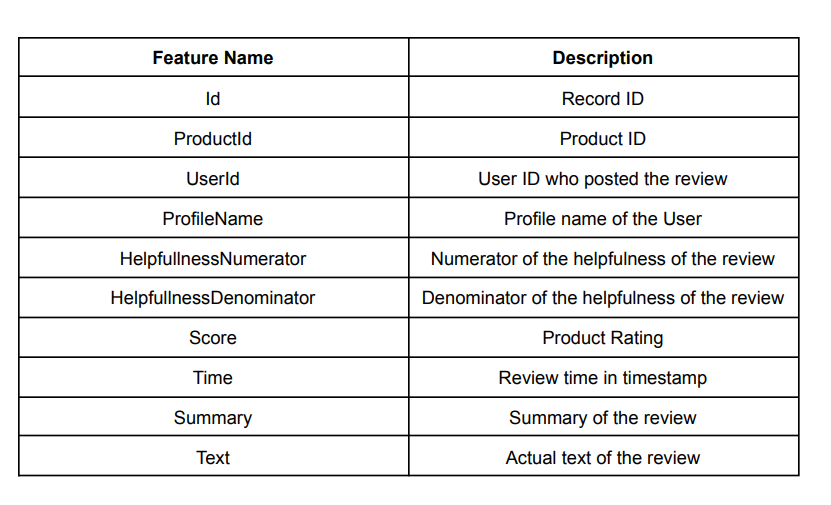

In [8]:
tw_data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
8698,8699,B003VXFK44,AHTACNRCJ00CG,bluebird60,2,2,5,1331596800,What a great cup of coffee,Sometimes I feel when I reach for a decaffeina...
411682,411683,B00613XOUI,A1E45FTKYXNMBC,"Janis ""Janis""",3,3,5,1335484800,great taste,This has a get taste if anyone that is looking...
504714,504715,B007I7YZJK,A3BH63GKL7MQ2K,"J. Roberts ""RP madman""",2,3,2,1339545600,You can really taste that sucralose,"To be fair, I think I'd give any of these mini..."
497964,497965,B000LKVD5U,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1237075200,"One bite and you'll become a ""chippoisseur""","As an Oregonian, I make a point of sharing the..."
559153,559154,B000VVUQAW,A3V54VTCAT3SCS,Elizabeth Howard,0,0,5,1252886400,every dog loves these treats!,These all natural treats are a favorite for my...


In [9]:
tw_data.shape

(568454, 10)

## Data Pre-processing

Deduplication means removing duplicate rows, It is necessary to remove duplicates in order to get unbaised results. 
Checking duplicates based on UserId, ProfileName, Time, Text. If all these values are equal then we will remove those records.
(No user can type a review on same exact time for different products.)

In [10]:
tw_data = tw_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [11]:
tw_data.shape

(393933, 10)

In [12]:
tw_data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

As seen above 27 values are missing from summary and 16 values are missing from profile name. Profile name won't add any impact as we got IDs. We can still get sentiment from the score column,hence we will not drop it rather fill it
with "No Summary Available" and fill missing profile name with 'unknown'.

In [13]:
tw_data['ProfileName'] = tw_data['ProfileName'].fillna('Unknown')

In [14]:
tw_data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   3
Text                      0
dtype: int64

In [15]:
tw_data['Summary'] = tw_data['Summary'].fillna('No Summary Available')

In [16]:
tw_data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

For generating sentiment we will see the score to get an idea and then go for classification. If we had only text and summary, using sentiment vader would have made sense. Here score makes it crystal clear about the sentiment of the customer.
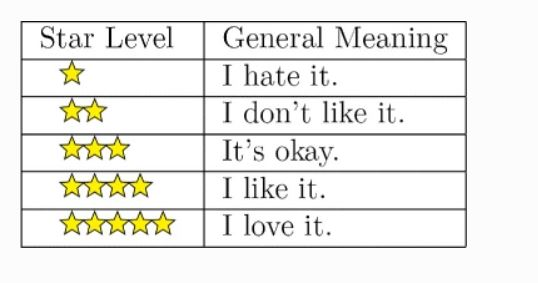
Source:https://journalofbigdata.springeropen.com/articles/10.1186/s40537-015-0015-2 

In [17]:
tw_data['Score'].value_counts()

5    250962
4     56094
1     36306
3     29769
2     20802
Name: Score, dtype: int64

Creating the sentiment column.
As seen from the above image if the score is greater than 3, we take that as positive and if the value is less than 3 it is negative.
If it is equal to 3, we take that as neutral sentiment.

In [18]:
def f(record):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if record['Score'] == 3.0:
        val = 'Neutral'
    elif record['Score'] == 1.0 or record['Score'] == 2.0:
        val = 'Negative'
    elif record['Score'] == 4.0 or record['Score'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [19]:
#Applying the above function to our new column
tw_data['sentiment'] = tw_data.apply(f, axis=1)
tw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [20]:
spacy_data = tw_data

In [21]:
tw_data['sentiment'].value_counts()

Positive    307056
Negative     57108
Neutral      29769
Name: sentiment, dtype: int64

In [22]:
#By productID which got max and minimum positive and negative reviews.
#By profile name who was the most active reviewer.Group by name Profile name and helpfulness numerator
#Which profile name has given the most positive or negative reviews.
#Find unique product IDs and then which product ids have no summary available.

In [23]:
max_product_reviews = tw_data.groupby(['ProductId','ProfileName'])['Score'].count().sort_values(ascending=False,)


In [24]:

max_product_reviews[:10]

ProductId   ProfileName                           
B001E5DXEU  A Customer                                9
B006N3I69A  A Customer                                8
B000ENUC3S  A Customer                                8
B000FBM3RC  A Customer                                7
B000FYYOYO  Nicholas Walker "Savage"                  6
B003D4F1QS  IrishFire                                 6
B0018KR8V0  Andrea "Readaholic"                       6
B000GINU0S  Kathy W                                   6
B003CK2BQG  Rebecca of Amazon "The Rebecca Review"    5
B000WFUL3E  HTBK                                      5
Name: Score, dtype: int64

In [25]:
tw_data['HelpfulnessNumerator'].value_counts()

0      207283
1       80531
2       37874
3       20832
4       12475
        ...  
247         1
170         1
179         1
454         1
808         1
Name: HelpfulnessNumerator, Length: 230, dtype: int64

In [26]:
df_user = tw_data.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
AY12DBB0U420B  Gary Peterson                                   329    4.659574
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                278    4.546763
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          259    4.787645
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 214    4.621495
A1Z54EM24Y40LL c2                                              211    4.383886
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             161    3.826087
A3D6OI36USYOU1 Ghenghis                                        146    4.417808
AZV26LP92E6WU  M. Hammond "ColemanFlGuy"                       129    4.852713
AKMEY1BSHSDG7  J. Arena                                        119    4.747899
A2GEZJHBV92EVR History buff                                    118    4.542373


Finding the helpfulness of the review
Source:https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/wi15/Shitij_Bhargava.pdf
HelfulnessNumerator says about number of people found that review usefull and HelpfulnessDenominator is about usefull review count + not so usefull count. So, from this we can see that HelfulnessNumerator is always less than or equal to HelpfulnesDenominator. Checking for above condition.

In [27]:
tw_data.info()
tw_data.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393933 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393933 non-null  int64 
 1   ProductId               393933 non-null  object
 2   UserId                  393933 non-null  object
 3   ProfileName             393933 non-null  object
 4   HelpfulnessNumerator    393933 non-null  int64 
 5   HelpfulnessDenominator  393933 non-null  int64 
 6   Score                   393933 non-null  int64 
 7   Time                    393933 non-null  int64 
 8   Summary                 393933 non-null  object
 9   Text                    393933 non-null  object
 10  sentiment               393933 non-null  object
dtypes: int64(5), object(6)
memory usage: 36.1+ MB


(393933, 11)

In [28]:
tw_data = tw_data[tw_data['HelpfulnessNumerator'] <= tw_data['HelpfulnessDenominator']]

In [29]:
tw_data["Useful %"] = (tw_data["HelpfulnessNumerator"]/tw_data["HelpfulnessDenominator"]).apply(lambda n: "useful" if n > 0.8 else "useless")

In [30]:
tw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,Useful %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,useless
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,useless


In [31]:
tw_data["Useful %"].value_counts()

useless    252465
useful     141466
Name: Useful %, dtype: int64

Tokenization

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

tw_data["Summary_Clean"] = tw_data["Summary"].apply(cleanup)

In [33]:
tw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,Useful %,Summary_Clean
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,useful,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,useless,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,useful,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,useful,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,useless,great taffy


In [34]:
tw_data['Text'][233]

"Terrible! Artificial lemon taste, like Pledge Lemon Furniture Polish. Don't do this to yourself. Just use plain flake salt and some fresh grated lemon zest."

In [35]:
text = " ".join(review for review in tw_data.Summary_Clean)

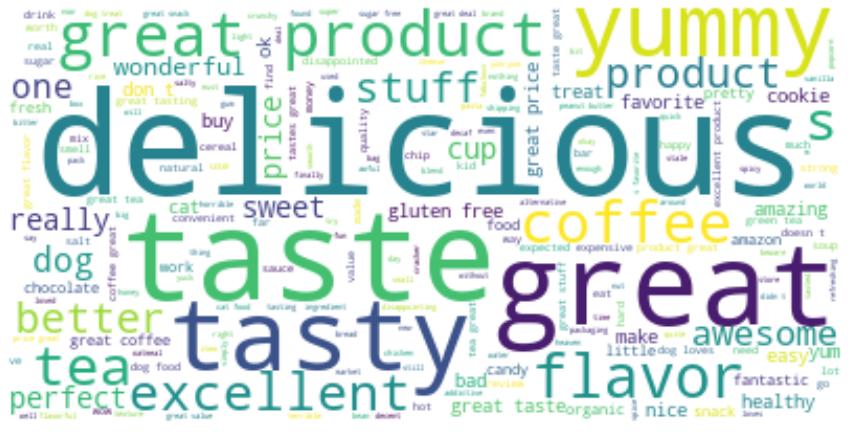

In [36]:
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["good", "love", "best"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


As seen most of the reviews are positive and related to food items. The sentiments are overall positive. 

### Word cloud for negative reviews

In [37]:
tw_neg_wc = tw_data.loc[lambda tw_data: tw_data['sentiment'] == 'Negative']
tw_neg_wc.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,Useful %,Summary_Clean
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,useless,not as advertised
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,useful,cough medicine
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,Negative,useful,my cats are not fans of the new food
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,Negative,useless,poor taste
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",Negative,useless,nasty no flavor


In [38]:
text1 = " ".join(review for review in tw_neg_wc.Summary_Clean)

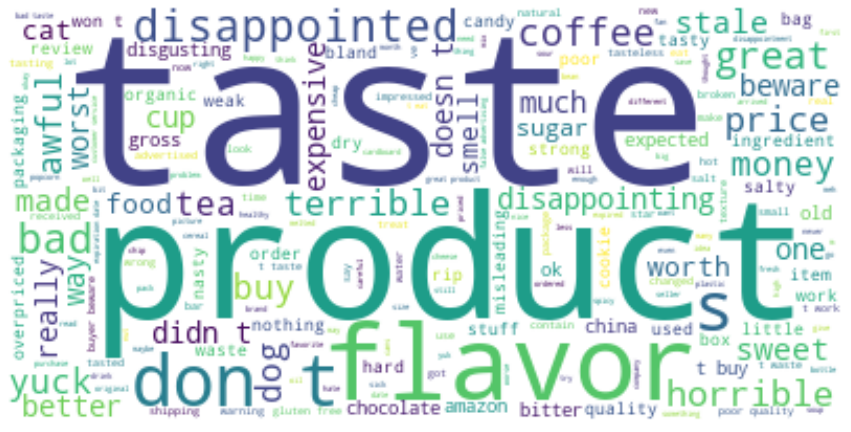

In [39]:
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["good", "love", "best"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text1)

# Display the generated image:
# the matplotlib way:
fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Cleaning the data
To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

1.Stemming
2.Stop words removal
3.Lowering
4.Tokenization
5.Pruning (numbers and punctuation)

In [40]:
sample_review=tw_data.Text[30]
sample_review

"I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)"

In [41]:
parsed_review = nlp(sample_review)
parsed_review

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)

In [42]:
food_reviews_df = tw_data[['Text','Score']]

In [43]:
food_reviews_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


Part-of-speech tagging

After tokenization we can parse and tag variety of parts of speech to paragraph text. SpaCy uses statistical models in background to predict which tag will go for each word(s) based on the context.

Lemmatization
It is the process of extracting uninflected/base form of the word. Lemma can be like For eg.

Adjectives: best, better → good Adverbs: worse, worst → badly Nouns: ducks, children → duck, child Verbs: standing,stood → stand

In [44]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:10]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,"(I,)",PRON,PRP,nsubj,X,True,True,False
1,have,"(have,)",AUX,VBP,aux,xxxx,True,True,False
2,never,"(never,)",ADV,RB,neg,xxxx,True,True,False
3,been,"(be,)",AUX,VBN,ROOT,xxxx,True,True,False
4,a,"(a,)",DET,DT,det,x,True,True,False
5,huge,"(huge,)",ADJ,JJ,amod,xxxx,True,False,False
6,coffee,"(coffee,)",NOUN,NN,compound,xxxx,True,False,False
7,fan,"(fan,)",NOUN,NN,attr,xxx,True,False,False
8,.,"(.,)",PUNCT,.,punct,.,False,False,True
9,However,"(however,)",ADV,RB,advmod,Xxxxx,True,True,False


Processing noun chunks

In [45]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:10]

,text,root,root.text,root.dep_,root.head.text
0,I,"(I,)","(I,)",nsubj,been
1,a huge coffee fan,"(fan,)","(fan,)",attr,been
2,my mother,"(mother,)","(mother,)",nsubj,purchased
3,this little machine,"(machine,)","(machine,)",dobj,purchased
4,me,"(me,)","(me,)",dobj,talked
5,the Latte Macciato,"(Macciato,)","(Macciato,)",dobj,trying
6,No Coffee Shop,"(Shop,)","(Shop,)",nsubj,has
7,I,"(I,)","(I,)",nsubj,like
8,the other products,"(products,)","(products,)",pobj,of
9,a usually non-coffee drinker!).<br,"(drinker!).<br,)","(drinker!).<br,)",pobj,as


## Modeling and choosing the algorithms

In [46]:
train_df=food_reviews_df[:100000]


In [47]:
train_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [48]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
Score = train_df['Score']
Score = Score.map(partition)
Summary = train_df['Text']
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [49]:
tmp = train_df
tmp['Score'] = tmp['Score'].map(partition)
print(tmp.head(20))

                                                 Text     Score
0   I have bought several of the Vitality canned d...  positive
1   Product arrived labeled as Jumbo Salted Peanut...  negative
2   This is a confection that has been around a fe...  positive
3   If you are looking for the secret ingredient i...  negative
4   Great taffy at a great price.  There was a wid...  positive
5   I got a wild hair for taffy and ordered this f...  positive
6   This saltwater taffy had great flavors and was...  positive
7   This taffy is so good.  It is very soft and ch...  positive
8   Right now I'm mostly just sprouting this so my...  positive
9   This is a very healthy dog food. Good for thei...  positive
10  I don't know if it's the cactus or the tequila...  positive
11  One of my boys needed to lose some weight and ...  positive
12  My cats have been happily eating Felidae Plati...  negative
13  good flavor! these came securely packed... the...  positive
14  The Strawberry Twizzlers are my guil

In [50]:
cvec = CountVectorizer(lowercase=True, strip_accents="ascii",
                       ngram_range=(1, 1), stop_words="english", min_df=10)
cvec.fit(tmp["Text"])
vectorizedData = cvec.transform(tmp["Text"])

In [51]:
vectorizedData.shape

(100000, 12713)

In [52]:
# Model Building
# Preprocessing target Variable
tmp["Score"]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(tmp['Score'])
tmp['Score_encoded'] = le.transform(tmp['Score'])
le.classes_

array(['negative', 'positive'], dtype=object)

In [53]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectorizedData, tmp['Score'], 
                                                    test_size=0.2, random_state=42)

In [54]:
# Model Fit
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [55]:
# Model evaluation
from sklearn.metrics import classification_report
preds = clf.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

    negative       0.87      0.23      0.37      2948
    positive       0.88      0.99      0.93     17052

    accuracy                           0.88     20000
   macro avg       0.87      0.61      0.65     20000
weighted avg       0.88      0.88      0.85     20000



In [56]:
# Prediction on a new sentence
inputstring = ['The game was absolutely amazing ! Really loved the participation', 
            'We had a bad day at the event']

In [57]:
## Countvec
vectorizedData = cvec.transform(inputstring)

In [58]:
## Predict
clf.predict(vectorizedData)

array(['positive', 'positive'], dtype=object)

In [59]:
# Prediction on a new sentence
inputstring1 = ['It is terrible. The taste is bad and very expensive.']

In [60]:
## Countvec
vectorizedData1 = cvec.transform(inputstring1)

In [61]:
## Predict
clf.predict(vectorizedData1)

array(['negative'], dtype=object)

Text classification Using SpaCy 
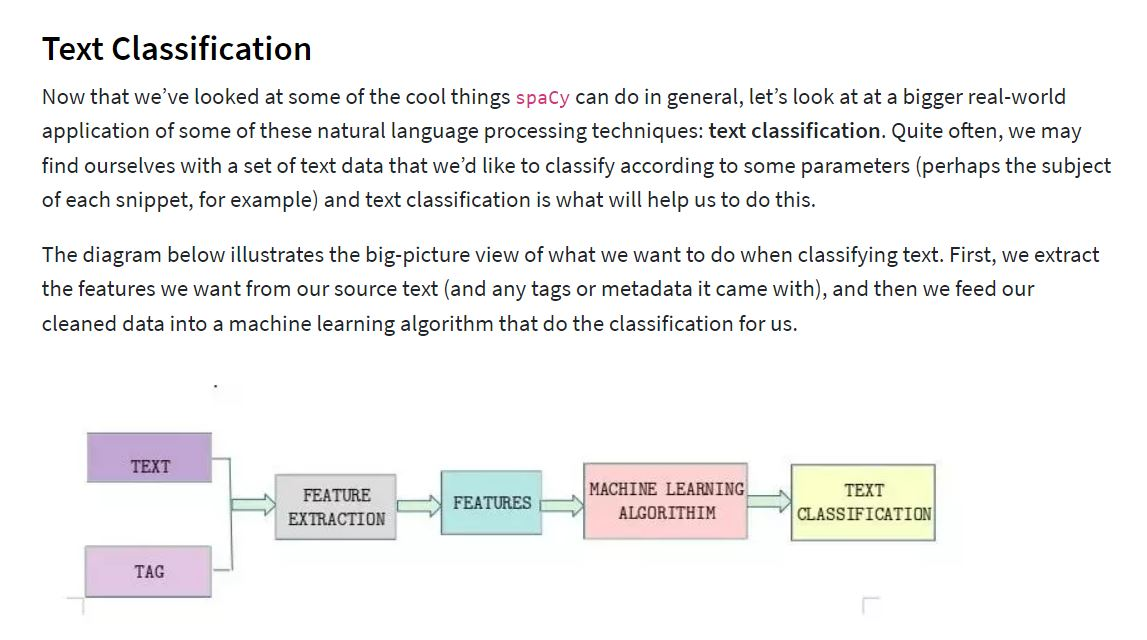

Source:https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [62]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [63]:
#!python -m spacy download en_core_web_lg

In [64]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_lg


In [65]:
from sklearn import metrics

In [66]:
nlp = en_core_web_lg.load()

In [67]:
spacy_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [68]:
spacy_data['sentiment'].value_counts()

Positive    307056
Negative     57108
Neutral      29769
Name: sentiment, dtype: int64

In [69]:
spacy_data[spacy_data['sentiment'] == 'Neutral']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
45,46,B001EO5QW8,A39Z97950MCTQE,K. A. Freel,0,0,3,1205193600,Hearty Oatmeal,This seems a little more wholesome than some o...,Neutral
47,48,B001EO5QW8,A26AY1TFK8BQXQ,"kbogo ""shoelover""",1,2,3,1200096000,Mushy,"The flavors are good. However, I do not see a...",Neutral
49,50,B001EO5QW8,A276999Y6VRSCQ,JMay,0,1,3,1334016000,Same stuff,This is the same stuff you can buy at the big ...,Neutral
53,54,B000G6RPMY,AQ9DWWYP2KJCQ,"Roel Trevino ""protomex""",0,0,3,1278028800,not ass kickin,we're used to spicy foods down here in south t...,Neutral
60,61,B004N5KULM,A1ZR8O62VSU4OK,"Lisa J. Szlosek ""lisa""",2,4,3,1318723200,Better price for this at Target,Watch your prices with this. While the assort...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
568336,568337,B001BOAOLY,A3CMHE6IJV79QM,Nancy J. Lumpkins,0,0,3,1285459200,Not Enough Lemon!,These taste basically as if there is no lemon ...,Neutral
568355,568356,B002XO3Q52,A7DMNT5YZ3JV1,RJT,0,0,3,1334534400,Paid too much,I paid well over labeled price and the produc...,Neutral
568369,568370,B000LKVRQA,A2ZX818P92CM7F,"Gregg Somers ""chillerdad""",1,2,3,1282694400,This is Earl Grey!???,"An admitted fan of Stash Earl Grey, neverthele...",Neutral
568379,568380,B000H28ABW,A1XVKAMXSOW8ZV,"C. E. Hunsicker ""Hatshepsut""",2,3,3,1256515200,Just OK,I hadn't tried this taco seasoning prior to pu...,Neutral


In [70]:
spacy_data['Text'][60]

'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.'

In [71]:
spacy_data['Text'][9982]

"This is a pleasant tea, it tastes mostly of chamomile.  Unfortunately for me, it doesn't do too much to squelch heartburn.  I'm now 36 weeks along and have had heartburn almost the whole time, and I was hoping this would help out but it really hasn't had an effect. I do like the tea just as a mild beverage, but I can't recommend it for pregnancy related heartburn."

To create more balanced sets we will upsample the data so that negative matches positive sentiments.

In [72]:
def neutral(record):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if record['Score'] <= 3.0:
        val = 'Negative'
    elif record['Score'] == 4.0 or record['Score'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [73]:
#Applying the above function to our new column
spacy_data['sentiment'] = spacy_data.apply(neutral, axis=1)
spacy_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [74]:
spacy_data['sentiment_num'] = spacy_data['sentiment'].map({'Positive': 1, 'Negative': 0})
spacy_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,sentiment_num
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


In [75]:
spacy_data['sentiment_num'].value_counts()

1    307056
0     86877
Name: sentiment_num, dtype: int64

In [76]:
amazon_reviews_df = spacy_data[['Text','sentiment_num']][:10000]

In [77]:
amazon_reviews_df['sentiment_num'].value_counts()

1    7646
0    2354
Name: sentiment_num, dtype: int64

In [78]:
# create the vector
amazon_reviews_df['vector']= amazon_reviews_df['Text'].apply(lambda x: nlp(x).vector)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(amazon_reviews_df.vector.values, amazon_reviews_df.sentiment_num, test_size=0.2, random_state=200)


In [80]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [81]:
X_train_2d

array([[-0.078781  ,  0.14729962, -0.16069397, ..., -0.09146054,
         0.04631582,  0.06383914],
       [-0.05213395,  0.14317004, -0.13914268, ..., -0.07913664,
         0.03152335,  0.11359029],
       [ 0.05486356,  0.20663278, -0.13259001, ..., -0.20039877,
        -0.02411179,  0.10752061],
       ...,
       [-0.0824999 ,  0.19917676, -0.16456628, ..., -0.02444633,
        -0.01086074,  0.11955824],
       [ 0.01356156,  0.1869605 , -0.21882436, ..., -0.02247087,
        -0.0047681 ,  0.13130727],
       [-0.0776881 ,  0.23446912, -0.11694268, ..., -0.23362474,
        -0.01247632,  0.08272266]], dtype=float32)

In [82]:
# now before applying sklearn models we need to scale the data because we have negative values in the vector and they don't work well with nlp sklearn models
# we will use minmax scaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_train_embed = scaler.fit_transform(X_train_2d)
scale_test_embed = scaler.transform(X_test_2d)

# now we can apply the sklearn models and will be the multinomial naive bayes, usually works well with nlp data

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

# fit the model
clf.fit(scale_train_embed, y_train)

MultinomialNB()

In [83]:
# now print the classification report

# import classification report
from sklearn.metrics import classification_report

y_pred = clf.predict(scale_test_embed)

# print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       454
           1       0.77      1.00      0.87      1546

    accuracy                           0.77      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.60      0.77      0.67      2000



In [84]:
# now i ll try the KNN Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

# create the model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

knn.fit(X_train_2d, y_train)

KNeighborsClassifier(metric='euclidean')

In [85]:
# now print the classification report

y_pred2 = knn.predict(X_test_2d)

# print the classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.59      0.38      0.47       454
           1       0.84      0.92      0.88      1546

    accuracy                           0.80      2000
   macro avg       0.71      0.65      0.67      2000
weighted avg       0.78      0.80      0.78      2000



## Inferences
We have used to 10000 record dataset for training. The accuracy would improve if we increase the number of records in training.
In model 3 we have used a large training dataset to see the effects.

#### Model 3 
As we only want to get the global sentiment of the recommendations (positive or negative), 
we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to 
"postive". Otherwise, it will be set to "negative".

In [108]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [109]:
messages = pd.read_csv(r'C:/Users/Astha/Downloads/Project/Reviews.csv')

In [110]:
messages = messages.loc[lambda df: df['Score'] != 3].reset_index(drop = True)

In [111]:
messages.shape

(525814, 10)

In [112]:
messages.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [113]:
messages= messages[['Score','Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator']]

In [114]:
messages.head()

,Score,Summary,HelpfulnessNumerator,HelpfulnessDenominator
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


Let's add the Sentiment column that turns the numeric score into either positive or negative.

Similarly, the Usefulness column turns the number of votes into a boolean.

In [115]:
messages["Sentiment"] = messages["Score"].apply(lambda score: "positive" if score > 3 else "negative")
messages["Usefulness"] = (messages["HelpfulnessNumerator"]/messages["HelpfulnessNumerator"]).apply(lambda n: "useful" if n > 0.8 else "useless")

messages.head(5)

,Score,Summary,HelpfulnessNumerator,HelpfulnessDenominator,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
1,1,Not as Advertised,0,0,negative,useless
2,4,"""Delight"" says it all",1,1,positive,useful
3,2,Cough Medicine,3,3,negative,useful
4,5,Great taffy,0,0,positive,useless


## Extracting features from Text data
Refer here: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [116]:
messages.Sentiment=messages.Sentiment.astype(str)
messages.Summary=messages.Summary.astype(str)

In [117]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

train, test = train_test_split(messages, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

420651 items in training data, 105163 in test data


In [118]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment"]
y_test = test["Sentiment"]

prediction = dict()

## Model Evaluation and Techniques

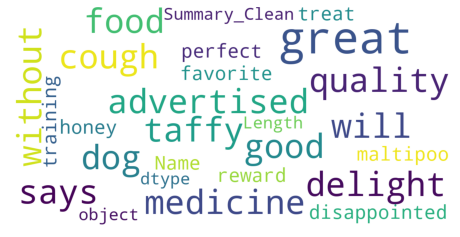

In [119]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])


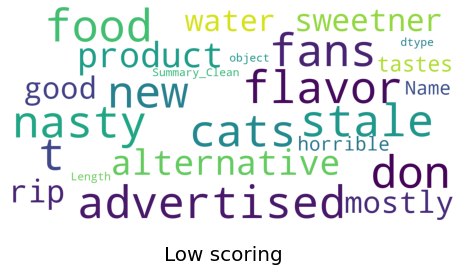

In [120]:
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Low scoring")

In [121]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [122]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [123]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

## Inferences
In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

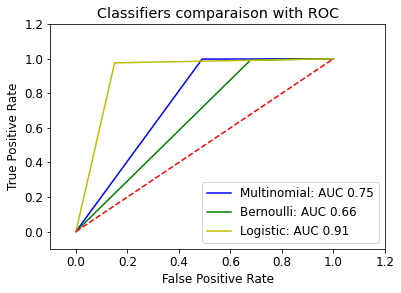

In [124]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As AUC of Logistic regression is highest we will use this algorithm for testing. Performance metrics will gives us idea on accuracy .

In [125]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.87      0.85      0.86     16463
    negative       0.97      0.98      0.97     88700

    accuracy                           0.96    105163
   macro avg       0.92      0.91      0.92    105163
weighted avg       0.96      0.96      0.96    105163



In [126]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')[:10]

,feature,coef
965268,worst,-100.081387
596606,not too good,-69.827454
568507,nasty,-69.450257
803328,tasteless,-69.093639
965131,worse,-62.254380
55211,at best,-60.353452
981867,yuk,-59.212928
517456,low quality,-58.112768
590861,not great,-56.352063
591043,not happy,-55.686637


In [127]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "The food was delicious, fresh  and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. There was bad smell and I felt sick inhaling that air ")
test_sample(logreg, "The food was fine I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as POSITIVE: negative prob 0.000000, positive prob 1.000000
Sample estimated as NEGATIVE: negative prob 1.000000, positive prob 0.000000
Sample estimated as NEGATIVE: negative prob 0.964510, positive prob 0.035490
